https://www.kdnuggets.com/2020/07/pull-analyze-financial-data-simple-python-package.html

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from urllib.request import urlopen

class FinanceAPI():
    """
    Core class
    """
    
    def __init__(self):
        """
        Initiates the object
        """
        self.key = ''
        self.key_registered = False
        pass
    
    def registerKey_(self,key):
        """
        Registers a secret API key to the object
        """
        assert type(key) is str,"Key must be a string"
        self.key = str(key)
        self.key_registered = True
    
    def __repr__(self):
        return ("This is a finance API class.\n")
    
    def profile_data_(self,symbol):
        """
        Pulls the metrics data from the API for the given ticker symbol
        Parameters
        ----------
        symbol : A ticker symbol (str) e.g. 'MSFT','FB','AAPL', or 'TWTR'
        Returns
        -------
        None. Updates the self.profile with the data. 
        """        
        if not self.key_registered:
            print("API key not registered yet.")
            return None
        
        url = "https://financialmodelingprep.com/api/v3/"+\
            "company/profile/"+str(symbol)+'?apikey='+self.key
        response = urlopen(url)
        data = response.read().decode("utf-8")
        self.profile = json.loads(data)
        
    def metrics_data_(self,symbol):
        """
        Pulls the metrics data from the API for the given ticker symbol
        Parameters
        ----------
        symbol : A ticker symbol (str) e.g. 'MSFT','FB','AAPL', or 'TWTR'
        Returns
        -------
        None. Updates the self.metrics with the data. 
        """
        if not self.key_registered:
            print("API key not registered yet.")
            return None
        
        url = "https://financialmodelingprep.com/api/v3/"+\
            "company-key-metrics/"+str(symbol)+'?apikey='+self.key
        response = urlopen(url)
        data = response.read().decode("utf-8")
        self.metrics = json.loads(data)
        
    def ratios_data_(self,symbol):
        """
        Pulls the ratios data from the API for the given ticker symbol
        Parameters
        ----------
        symbol : A ticker symbol (str) e.g. 'MSFT','FB','AAPL', or 'TWTR'
        Returns
        -------
        None. Updates the self.ratios with the data. 
        """
        if not self.key_registered:
            print("API key not registered yet.")
            return None
        
        url = "https://financialmodelingprep.com/api/v3/"+\
            "ratios/"+str(symbol)+'?apikey='+self.key
        response = urlopen(url)
        data = response.read().decode("utf-8")
        self.ratios = json.loads(data)
    
    def build_dict(self,symbol):
        """
        Builds a dictionary with a given ticker symbols
        
        Parameters
        ----------
        symbol : A ticker symbol (str) e.g. 'MSFT','FB','AAPL', or 'TWTR'
        Returns
        -------
        A dictionary with all the profile and metrics data pulled from the API
        """
        # Pull data
        if not self.key_registered:
            print("API key not registered yet.")
            return None
        
        self.profile_data_(symbol)
        self.metrics_data_(symbol)
        self.ratios_data_(symbol)
        # Empty dict
        data_dict = {}
        # Symbol
        data_dict['symbol']=symbol
        # Profile data
        for k in self.profile['profile'].keys():
            data_dict[k]=self.profile['profile'][k]
        # Metrics data
        for k in self.metrics['metrics'][0].keys():
            data_dict[k]=self.metrics['metrics'][0][k]
        # Ratios data
        c=[(k,v) for k,v in self.ratios[0].items()]
        for k in c[2:]:
            data_dict[k[0]]=k[1]

        return data_dict
    
    def available_data(self,data_type='profile'):
        """
        Prints a list of data items that are available
        
        Arguments
        ----------
        data_type: One of 'profile','metrics',or 'ratios'
        
        Returns
        --------
        None. Prints a list.
        """
        assert str(data_type) in ['profile','metrics','ratios'], \
        "Data type not recognized. Should be one of \'profile\',\'metrics\',or \'ratios\'"
        
        available_data = []
        if data_type=='profile':    
            for k in self.profile['profile'].keys():
                if self.profile['profile'][k] is not None:
                    available_data.append(k)
            print("Following data are available for profile")
            print("="*60)
            for d in available_data[:-1]:
                print(d,end=', ')
            print(available_data[-1],end='.')
        
        if data_type=='metrics':    
            for k in self.metrics['metrics'][0].keys():
                if self.metrics['metrics'][0][k] is not None:
                    available_data.append(k)
            print("Following data are available for metrics")
            print("="*60)
            for d in available_data[:-1]:
                print(d,end=', ')
            print(available_data[-1],end='.')
            
        if data_type=='ratios':    
            c=[(k,v) for k,v in self.ratios[0].items()]
            for k in c[2:]:
                if k[1] is not None:
                    available_data.append(k[0])
            print("Following data are available for ratios")
            print("="*60)
            for d in available_data[:-1]:
                print(d,end=', ')
            print(available_data[-1],end='.')
    
    def cols_numeric_(self):
        """
        Transforms columns to numeric (float) wherever applicable
        """
        for c in self.df.columns:
            try:
                self.df[c] = self.df[c].apply(float)
            except ValueError:
                pass
    
    def replace_None_(self):
        """
        Replaces NoneType data by np.nan in the DataFrame
        """
        self.df.fillna(value=np.nan, inplace=True)
    
    def build_dataframe(self,lst):
        """
        Builds a DataFrame with a given list of ticker symbols
        
        Parameters
        ----------
        lst : A list of ticker symbols (str) 
            e.g. ['MSFT','FB','AAPL','TWTR']
        Returns
        -------
        A Pandas DataFrame with all the data pulled from the API, 
        indexed by the symbol (company)
        """
        if not self.key_registered:
            print("API key not registered yet.")
            return None
        
        data_companies = []
        for c in lst:
            data_companies.append(self.build_dict(c))
        # Build the DataFrame
        self.df = pd.DataFrame(data_companies)
        # Convert to numeric columns wherever applicable
        self.replace_None_()
        self.cols_numeric_()
        
        return self.df
    
    def bar_chart(self,var='price',**kwargs):
        """
        Plots a bar chart of the given variable
        
        Parameters
        ----------
        var : Name of the variable to be plotted (str)
            e.g. 'price', 'PE ratio', 'Book Value per Share'
        Returns
        -------
        None
        """
        plt.figure(figsize=(10,4))
        plt.title("{}".format(var),fontsize=18)
        plt.bar(x=self.df['companyName'],height=self.df[var],**kwargs)
        plt.xticks(fontsize=14,rotation=45)
        plt.yticks(fontsize=14)
        plt.ylabel(var,fontsize=16)
        plt.show()
    
    def scatter(self,varX,varY,sizeZ=None,**kwargs):
        """
        Plots a scatter chart of the given variable pair,
        and (optionally) size the as per a third variable
        
        Parameters
        ----------
        varX : Name of the x-axis variable (str), e.g. 'price', 'PE ratio', 'Book Value per Share'
        varY : Name of the x-axis variable (str), e.g. 'price', 'PE ratio', 'Book Value per Share'
        sizeZ : Name of the variable (str) for sizing, e.g. 'price', 'PE ratio', 'Book Value per Share'
        Returns
        -------
        None
        """
        if sizeZ is not None:
            scale = 1000/(self.df[sizeZ].max()**2)
        plt.figure(figsize=(10,4))
        plt.title("{} vs. {}".format(varX,varY),fontsize=18)
        if sizeZ is not None:
            plt.scatter(x=self.df[varX],y=self.df[varY],s=scale*self.df[sizeZ]**2,**kwargs)
        else:
            plt.scatter(x=self.df[varX],y=self.df[varY],s=200,**kwargs)
        for i in (range(len(self.df))):
            plt.annotate(s=self.df['symbol'][i],
                         xy=(self.df[varX][i],
                             self.df[varY][i]))
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel(varX,fontsize=16)
        plt.ylabel(varY,fontsize=16)
        plt.show()

In [31]:
key = '1c3f5c130800f01d6484269bc0f70741'
f = FinanceAPI()
f.registerKey_(key)
print(f)

This is a finance API class.



In [32]:
f.build_dict('AAPL')

{'symbol': 'AAPL',
 'price': 134.76,
 'beta': '1.27241',
 'volAvg': '82446450',
 'mktCap': '2143775490048',
 'lastDiv': '0.91',
 'range': '124.17-179.61',
 'changes': 1.34999,
 'changesPercentage': '1.0119113',
 'companyName': 'Apple Inc.',
 'exchange': 'NASDAQ Global Select',
 'exchangeShortName': 'NASDAQ',
 'industry': 'Consumer Electronics',
 'website': 'https://www.apple.com',
 'description': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. In addition, the company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. Further, it provides AppleCare support and cloud services store services; and operates various platforms, including the App Store that allow customers to discover and download application

In [33]:
stocks = ['AAPL', 'META', 'MSFT', 'NVDA']
data = f.build_dataframe(stocks)

In [34]:
data

,symbol,price,beta,volAvg,mktCap,lastDiv,range,changes,changesPercentage,companyName,...,priceToSalesRatio,priceEarningsRatio,priceToFreeCashFlowsRatio,priceToOperatingCashFlowsRatio,priceCashFlowRatio,priceEarningsToGrowthRatio,priceSalesRatio,dividendYield,enterpriseValueMultiple,priceFairValue
0,AAPL,134.76,1.272410,82446450.0,2.143775e+12,0.91,124.17-179.61,1.349990,1.011911,Apple Inc.,...,6.145837,24.282593,21.746324,19.839998,19.839998,2.868381,6.145837,0.006124,18.926968,47.826721
1,META,136.98,1.164283,44587612.0,3.591890e+11,0.00,88.09-328.0,0.269989,0.197490,"Meta Platforms, Inc.",...,7.201906,21.572609,21.712691,14.723812,14.723812,0.584807,7.201906,NaN,15.195750,6.801092
2,MSFT,239.23,0.926403,30194866.0,1.783333e+12,2.54,213.43-315.95,0.720001,0.301875,Microsoft Corporation,...,10.613945,28.931603,32.301754,23.635952,23.635952,1.486865,10.613945,0.008618,21.466355,12.636014
3,NVDA,168.99,1.722009,47717154.0,4.211231e+11,0.16,108.13-289.46,3.880000,2.349951,NVIDIA Corporation,...,21.772532,60.088795,72.059263,64.337498,64.337498,0.489354,21.772532,0.000681,52.478454,22.019613


In [35]:
f.available_data('profile')

Following data are available for profile
price, beta, volAvg, mktCap, lastDiv, range, changes, changesPercentage, companyName, exchange, exchangeShortName, industry, website, description, ceo, sector, country, fullTimeEmployees, phone, address, city, state, zip, ipoDate, currency, isin, cusip, cik, image, defaultImage, isEtf, isActivelyTrading, isFund, isAdr.

In [36]:
f.available_data('metrics')

Following data are available for metrics
date, Revenue per Share, Net Income per Share, Operating Cash Flow per Share, Free Cash Flow per Share, Cash per Share, Book Value per Share, Tangible Book Value per Share, Shareholders Equity per Share, Interest Debt per Share, Market Cap, Enterprise Value, PE ratio, Price to Sales Ratio, POCF ratio, PFCF ratio, PB ratio, PTB ratio, EV to Sales, Enterprise Value over EBITDA, EV to Operating cash flow, EV to Free cash flow, Earnings Yield, Free Cash Flow Yield, Debt to Equity, Debt to Assets, Net Debt to EBITDA, Current ratio, Interest Coverage, Income Quality, Dividend Yield, Payout Ratio, SG&A to Revenue, R&D to Revenue, Intangibles to Total Assets, Capex to Operating Cash Flow, Capex to Revenue, Capex to Depreciation, Stock-based compensation to Revenue, Graham Number, ROIC, Return on Tangible Assets, Graham Net-Net, Working Capital, Tangible Asset Value, Net Current Asset Value, Invested Capital, Average Receivables, Average Payables, Averag

In [37]:
f.available_data('ratios')

Following data are available for ratios
period, currentRatio, quickRatio, cashRatio, daysOfSalesOutstanding, daysOfInventoryOutstanding, operatingCycle, daysOfPayablesOutstanding, cashConversionCycle, grossProfitMargin, operatingProfitMargin, pretaxProfitMargin, netProfitMargin, effectiveTaxRate, returnOnAssets, returnOnEquity, returnOnCapitalEmployed, netIncomePerEBT, ebtPerEbit, ebitPerRevenue, debtRatio, debtEquityRatio, longTermDebtToCapitalization, interestCoverage, cashFlowToDebtRatio, companyEquityMultiplier, receivablesTurnover, payablesTurnover, inventoryTurnover, fixedAssetTurnover, assetTurnover, operatingCashFlowPerShare, freeCashFlowPerShare, cashPerShare, payoutRatio, operatingCashFlowSalesRatio, freeCashFlowOperatingCashFlowRatio, capitalExpenditureCoverageRatio, dividendPaidAndCapexCoverageRatio, dividendPayoutRatio, priceBookValueRatio, priceToBookRatio, priceToSalesRatio, priceEarningsRatio, priceToFreeCashFlowsRatio, priceToOperatingCashFlowsRatio, priceCashFlowRatio

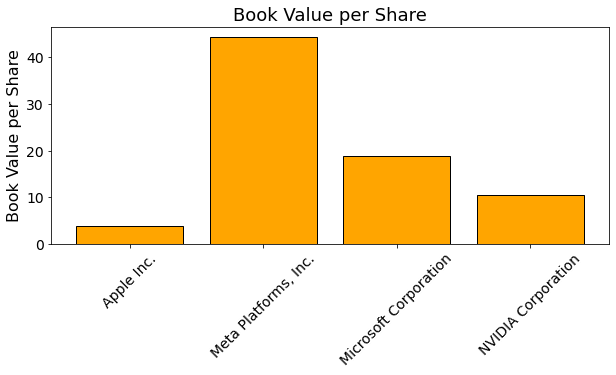

In [39]:
f.bar_chart('Book Value per Share', color='orange', edgecolor='k')

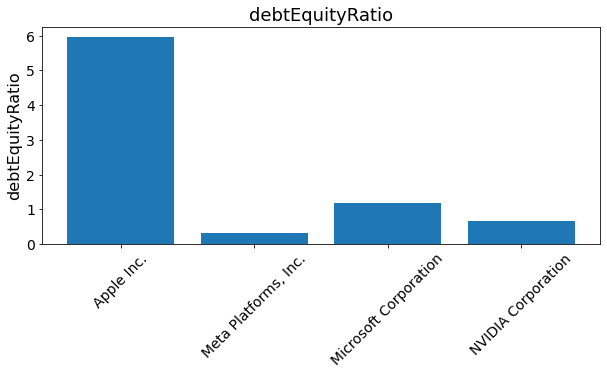

In [40]:
f.bar_chart('debtEquityRatio')

TypeError: annotate() missing 1 required positional argument: 'text'

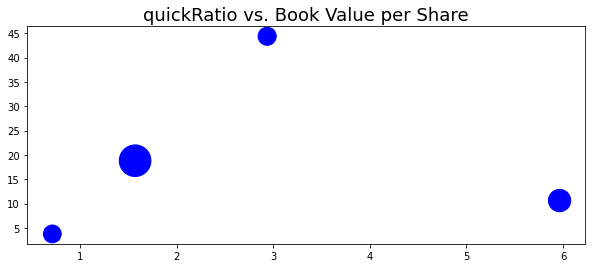

In [42]:
f.scatter('quickRatio', 'Book Value per Share', sizeZ='price', color='blue')